# Цель проекта: 
Разработать модель машинного обучения, которая на вход получает текстовую расшифровку голосового сообщения и возвращает класс эмоций.

In [54]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Модули для предобработки текста
import re
import string
import gensim
from gensim import corpora

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Модели и метрики
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Алгоритмы классификации
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка датасета
df = pd.read_csv('Фразы-эмоции.csv')

# Просмотр первых пяти строк датасета
print(df.head())

                                         Текст фразы        Эмоция
0  Я не могу поверить, что ты снова опоздал на ва...  Недовольство
1  Врач, к которому меня направили, оказался груб...  Недовольство
2  Как же меня раздражает твоя привычка постоянно...  Недовольство
3  Мне кажется, что некоторые врачи просто зараба...  Недовольство
4  Мне надоело слушать твои бесконечные жалобы и ...  Недовольство


In [3]:
# Проверка на наличие пропущенных значений
print(df.isnull().sum())

# Если есть пропуски, удаляем их
df.dropna(inplace=True)

Текст фразы    0
Эмоция         0
dtype: int64


In [4]:
# Проверка наличия дубликатов
print(f"Количество дубликатов: {df.duplicated().sum()}")

# Удаление дубликатов
df.drop_duplicates(inplace=True)

Количество дубликатов: 4


In [ ]:
# Статистика
print(df['Эмоция'].describe())

count           1039
unique             8
top       Нейтрально
freq             204
Name: Эмоция, dtype: object


In [ ]:
# Статистика
print(df['Текст фразы'].describe())

count                                                  1039
unique                                                 1039
top       Я не могу поверить, что ты снова опоздал на ва...
freq                                                      1
Name: Текст фразы, dtype: object


In [18]:
df['text_length'] = df['Текст фразы'].apply(len)
print(df['text_length'].describe())

count    1039.000000
mean       93.227141
std        38.773220
min        24.000000
25%        63.000000
50%        88.000000
75%       120.000000
max       346.000000
Name: text_length, dtype: float64


Эмоция
Нейтрально      204
Радость         161
Сочувствие      144
Злость          141
Печаль          133
Зависть         125
Интерес         117
Недовольство     14
Name: count, dtype: int64


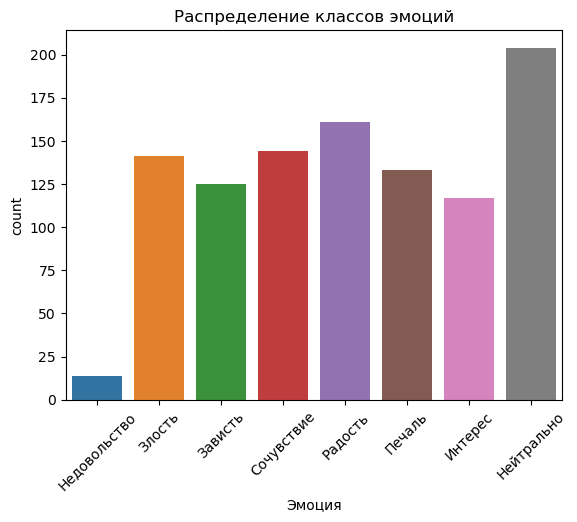

In [7]:
# Распределение классов эмоций
print(df['Эмоция'].value_counts())

sns.countplot(x='Эмоция', data=df)
plt.title('Распределение классов эмоций')
plt.xticks(rotation=45)
plt.show()

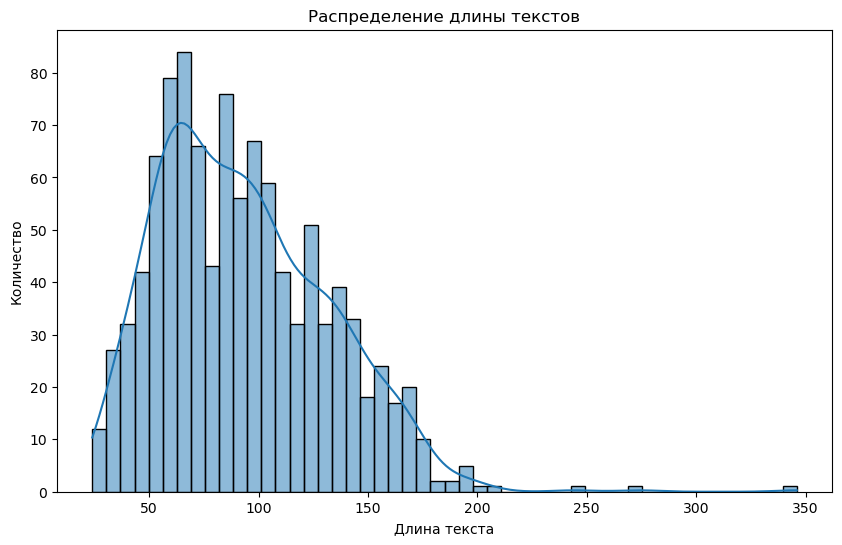

In [19]:
# Построим график распределения длины текстов, чтобы лучше понять форму и выявить аномалии.
plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.title('Распределение длины текстов')
plt.show()

In [20]:
# Определим статистические показатели:
print("Средняя длина текста:", df['text_length'].mean())
print("Медианная длина текста:", df['text_length'].median())
print("Наиболее частая длина текста (мода):", df['text_length'].mode()[0])
print("Стандартное отклонение длины текста:", df['text_length'].std())

Средняя длина текста: 93.22714148219441
Медианная длина текста: 88.0
Наиболее частая длина текста (мода): 84
Стандартное отклонение длины текста: 38.77322033609551


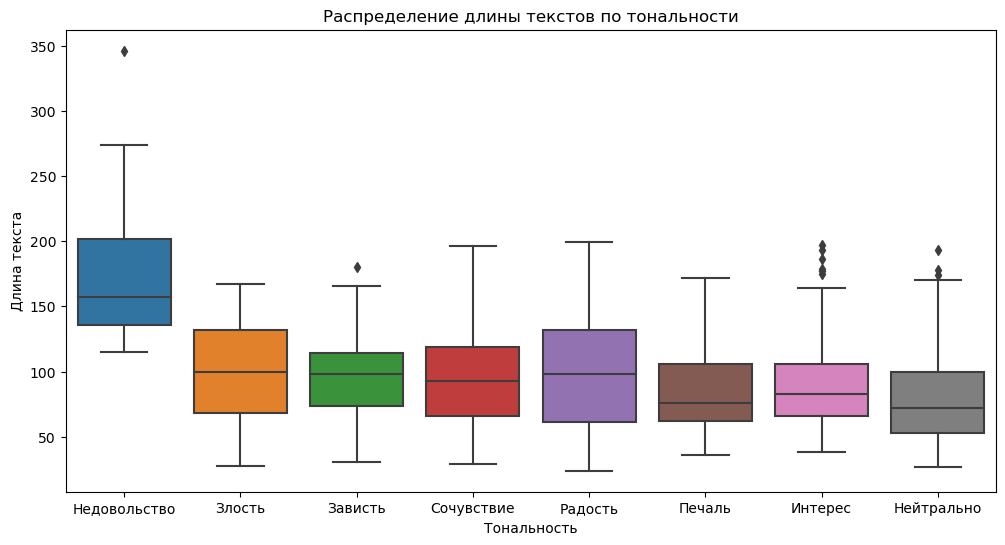

In [21]:
# Исследование связи длины текстов с тональностью:
plt.figure(figsize=(12,6))
sns.boxplot(x='Эмоция', y='text_length', data=df)
plt.xlabel('Тональность')
plt.ylabel('Длина текста')
plt.title('Распределение длины текстов по тональности')
plt.show()

In [22]:
# Найдем выбросы:
# Самые короткие тексты
print(df[df['text_length'] == df['text_length'].min()]['Текст фразы'])

# Самые длинные тексты
print(df[df['text_length'] == df['text_length'].max()]['Текст фразы'])

562    Я так счастлива за тебя!
Name: Текст фразы, dtype: object
9    Я потратил(а) несколько часов, ожидая приёма у...
Name: Текст фразы, dtype: object


In [23]:
# Количество пустых текстов (длина текста равна нулю)
empty_texts = df[df['text_length'] == 0]
num_empty_texts = empty_texts.shape[0]
print(f"Количество пустых текстов: {num_empty_texts}")

Количество пустых текстов: 0


In [24]:
# Удаление строк с пустыми текстами из набора данных, если необходимо
df = df[df['text_length'] > 0]
print(f"\nНовый размер набора данных после удаления пустых текстов: {df.shape}")


Новый размер набора данных после удаления пустых текстов: (1039, 4)


In [25]:
# Обработка необычно длинных текстов
# Определение порога максимальной длины текста (например, 95-й перцентиль)
max_length_threshold = df['text_length'].quantile(0.95)
print(f"Порог максимальной длины текста (95-й перцентиль): {max_length_threshold}")

# Количество текстов, превышающих порог
long_texts = df[df['text_length'] > max_length_threshold]
num_long_texts = long_texts.shape[0]
print(f"Количество текстов, превышающих порог максимальной длины: {num_long_texts}")

# Просмотр примеров длинных текстов
print("\nПримеры длинных текстов:")
print(long_texts.head())

Порог максимальной длины текста (95-й перцентиль): 162.0999999999999
Количество текстов, превышающих порог максимальной длины: 52

Примеры длинных текстов:
                                         Текст фразы        Эмоция  \
0  Я не могу поверить, что ты снова опоздал на ва...  Недовольство   
1  Врач, к которому меня направили, оказался груб...  Недовольство   
3  Мне кажется, что некоторые врачи просто зараба...  Недовольство   
5  В нашей стране медицина находится в ужасном со...  Недовольство   
6  Ты думаешь, что можешь просто так взять и уйти...  Недовольство   

                                  текст_обработанный  text_length  
0  мог повер снов опозда важн встреч эт прост неп...          192  
1  врач котор направ оказа груб невнимательн чело...          274  
3  кажет некотор врач прост зарабатыва деньг паци...          205  
5  наш стран медицин наход ужасн состоян врач пер...          244  
6  дума можеш прост взят уйт объясн причин сво по...          172  


In [27]:
# Решение: либо обрезать тексты до максимальной длины, либо удалить их. 
# Обрежем тексты для сохранения информации.

def truncate_text(text, max_length):
    return text[:int(max_length)]

df['Текст фразы'] = df['Текст фразы'].apply(lambda x: truncate_text(x, max_length_threshold))
df['text_length'] = df['Текст фразы'].apply(len)

print("\nТексты обрезаны до максимальной длины.")

# Другой вариант: Удалить тексты, превышающие максимальную длину
# df = df[df['text_length'] <= max_length_threshold]
# print(f"\nНовый размер набора данных после удаления длинных текстов: {df.shape}")


Тексты обрезаны до максимальной длины.


In [40]:
# Предобработка текста
nltk.download('punkt')
nltk.download('stopwords')

# Создание списков стоп-слов и инициализация стеммера
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()
    # Удаляем цифры и знаки пунктуации
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов и стемминг
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return tokens  # Возвращаем список токенов

# Применяем функцию предобработки к тексту
df['текст_обработанный'] = df['Текст фразы'].apply(preprocess_text)

# Просмотр первых пяти строк после предобработки
print(df[['Текст фразы', 'текст_обработанный']].head())

# Создание словаря и корпуса
dictionary = corpora.Dictionary(df['текст_обработанный'])
corpus = [dictionary.doc2bow(text) for text in df['текст_обработанный']]

# Построение модели LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=2, id2word=dictionary, passes=15, random_state=42)

# Печать тем
for idx, topic in lda_model.print_topics(-1):
    print(f'**Тема {idx}**: {topic}')

[nltk_data] Downloading package punkt to C:\Users\vikib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vikib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         Текст фразы  \
0  Я не могу поверить, что ты снова опоздал на ва...   
1  Врач, к которому меня направили, оказался груб...   
2  Как же меня раздражает твоя привычка постоянно...   
3  Мне кажется, что некоторые врачи просто зараба...   
4  Мне надоело слушать твои бесконечные жалобы и ...   

                                  текст_обработанный  
0  [мог, повер, снов, опозда, важн, встреч, эт, п...  
1  [врач, котор, направ, оказа, груб, невниматель...  
2  [раздража, тво, привычк, постоя, перебива, дру...  
3  [кажет, некотор, врач, прост, зарабатыва, день...  
4  [надоел, слуша, тво, бесконечн, жалоб, ныт, на...  
**Тема 0**: 0.027*"эт" + 0.013*"очен" + 0.011*"ваш" + 0.009*"прост" + 0.008*"понима" + 0.008*"теб" + 0.007*"нужн" + 0.006*"снов" + 0.006*"сдела" + 0.006*"нов"
**Тема 1**: 0.033*"эт" + 0.018*"прост" + 0.015*"так" + 0.014*"все" + 0.011*"мог" + 0.010*"работ" + 0.010*"нов" + 0.010*"сегодн" + 0.006*"сво" + 0.006*"очен"



### **1. Интерпретация результатов LDA**

LDA (Latent Dirichlet Allocation) генерирует темы, каждая из которых представлена распределением вероятностей по словам. Для каждой темы показаны наиболее вероятные слова с соответствующими весами (коэффициентами), которые отражают важность слова в теме.

Пример:

**Тема 0:**
- 0.027*"эт"
- 0.013*"очен"
- 0.011*"ваш"
- и т.д.

**Как интерпретировать:**

- **Смотреть на самые значимые слова**: Обратите внимание на слова с наибольшими коэффициентами.
- **Искать смысловые связи**: Попытайтесь понять, какие общие темы или понятия объединяют эти слова.
- **Назначить название теме**: Исходя из наиболее вероятных слов, попробуйте дать каждой теме понятное название.

**Пример интерпретации:**

- **Тема 0** может быть связана с **"Общие обсуждения или приветствия"**, если слова "ваш", "теб", "очен" часто встречаются в контексте приветствий.
- **Тема 1** может быть связана с **"Работа и текущие дела"**, если слова "работ", "сегодн", "нов" часто связаны с обсуждением рабочих вопросов.

Однако, интерпретация может быть неочевидной, особенно если слова общие или предобработка данных была недостаточной.

### **2. Визуализация тем**

Посмотрим на связи между темами, чтобы увидеть, какие слова наиболее характерны для каждой темы.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # обратите внимание на gensim_models
import gensim

# Подготовка данных для визуализации
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False, n_jobs=1)
     
# Отображение визуализации в блокноте Jupyter Notebook
pyLDAvis.display(lda_display)

# Так как не используется Jupyter Notebook, сохраняем визуализацию в HTML файл
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

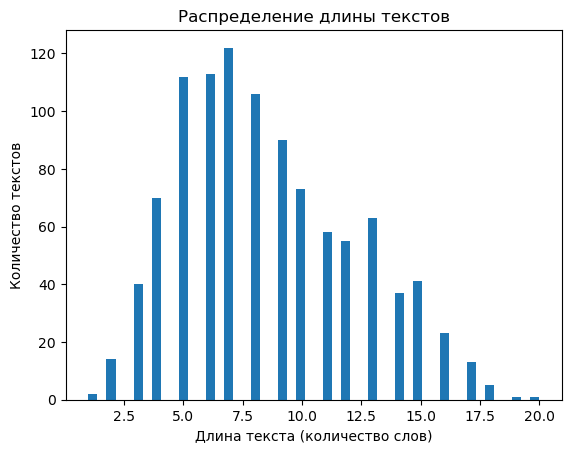

In [ ]:
# Подсчёт длины текста с учетом возможных ошибок
text_lengths = []
for text in df['текст_обработанный']:
    if isinstance(text, list):
        # Если элемент является списком, объединяем элементы в строку
        text = ' '.join(map(str, text))
    elif not isinstance(text, str):
        # Если элемент не строка и не список, преобразуем его в строку
        text = str(text)
    
    # Теперь разделитяем текст на слова и подсчитываем их количество
    text_length = len(text.split())
    text_lengths.append(text_length)

# Визуализация распределения длины текстов
plt.hist(text_lengths, bins=50)
plt.xlabel('Длина текста (количество слов)')
plt.ylabel('Количество текстов')
plt.title('Распределение длины текстов')
plt.show()
   


### Рассмотрим корреляцию между длиной текста и различными эмоциями

**Корреляция Пирсона:** 0.08
**Корреляция Спирмена:** 0.10


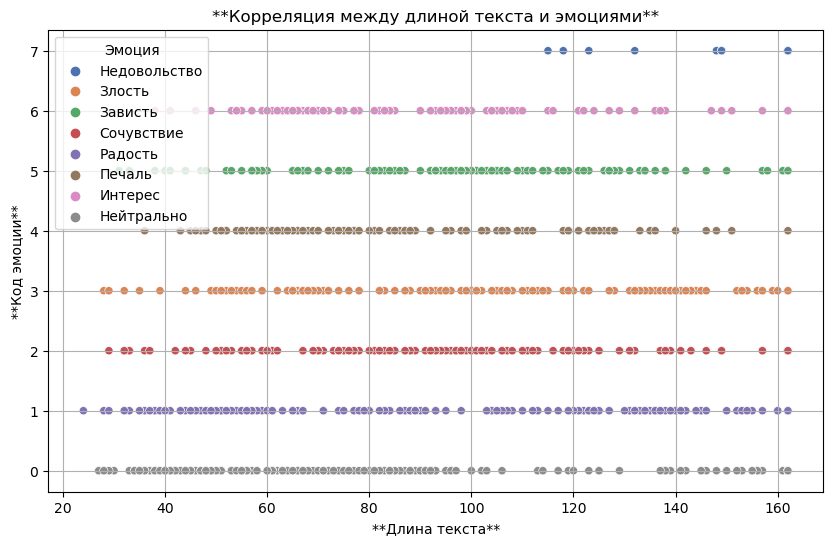

In [ ]:

# закодируем эмоции в числовые значения перед расчетом корреляции
from scipy.stats import pearsonr, spearmanr
emotion_mapping = {
    'Нейтрально': 0,
    'Радость': 1,
    'Сочувствие': 2,
    'Злость': 3,
    'Печаль': 4,
    'Зависть': 5,
    'Интерес': 6,
    'Недовольство': 7
}

df['код_эмоции'] = df['Эмоция'].map(emotion_mapping)

# Рассчитываем корреляцию Пирсона
pearson_corr, _ = pearsonr(df['text_length'], df['код_эмоции'])

# Рассчитываем корреляцию Спирмена
spearman_corr, _ = spearmanr(df['text_length'], df['код_эмоции'])

# Выводим результаты
print(f"**Корреляция Пирсона:** {pearson_corr:.2f}")
print(f"**Корреляция Спирмена:** {spearman_corr:.2f}")

# Построение графика распределения
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='код_эмоции', hue='Эмоция', data=df, palette='deep')
plt.title('**Корреляция между длиной текста и эмоциями**')
plt.xlabel('**Длина текста**')
plt.ylabel('**Код эмоции**')
plt.grid(True)
plt.show()

1. Корреляция Пирсона: 0.08
   - Эта корреляция измеряет линейную связь между двумя переменными.
   - Значение 0.08 указывает на очень слабую положительную линейную связь между длиной текста и эмоциями. Это означает, что практически нет линейной зависимости между этими двумя параметрами в ваших данных.

2. Корреляция Спирмена: 0.10
   - Это мера ранговой связи между переменными и подходит для данные, которые не обязательно имеют линейные зависимости.
   - Значение 0.10 также указывает на слабую положительную корреляцию по рангам. Это говорит о том, что даже при учете потенциальных нелинейных связей зависимости между длиной текста и эмоциями все еще слабые.

Интерпретация:
- Оба коэффициента корреляции показывают, что в данных нет значимой связи между длиной текста и эмоциями. 
- Также стоит помнить, что отсутствие корреляции не означает отсутствия какой-либо связи вообще, она может быть более сложной или зависящей от других факторов.

Подсчет частоты встречаемости слов

In [43]:
from collections import Counter
# Создание списка всех слов из обработанных текстов
all_words = [word for tokens in df['текст_обработанный'] for word in tokens]

# Подсчет частоты слов
word_counts = Counter(all_words)

# Топ-20 наиболее частых слов
print(word_counts.most_common(20))

[('эт', 327), ('прост', 150), ('все', 102), ('очен', 101), ('так', 95), ('мог', 90), ('нов', 86), ('сегодн', 68), ('теб', 66), ('работ', 60), ('ваш', 58), ('врем', 54), ('получ', 53), ('хотел', 53), ('сво', 50), ('сдела', 46), ('снов', 45), ('поч', 45), ('нужн', 45), ('понима', 44)]


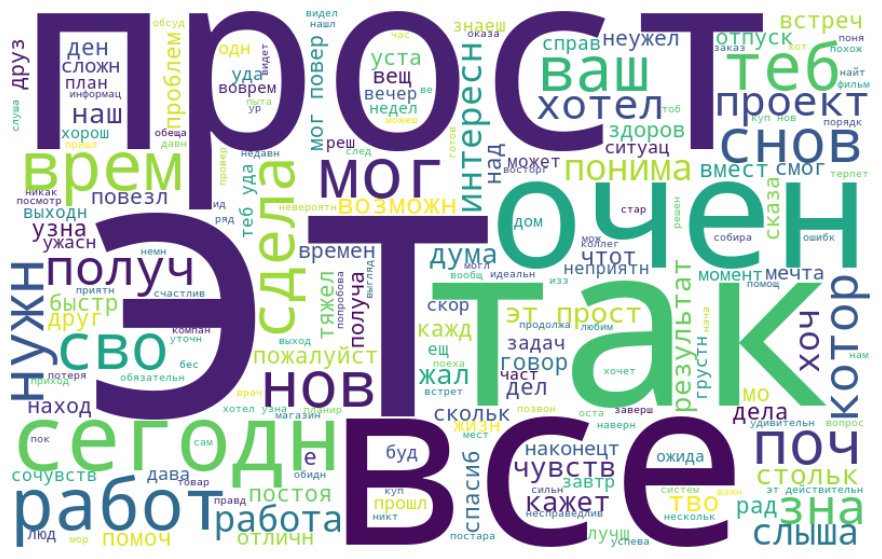

In [36]:
# Создание облака слов
from wordcloud import WordCloud

# Объединяем все обработанные тексты в одну строку
all_words = ' '.join([text for text in df['текст_обработанный']])

wordcloud = WordCloud(width=800, height=500, random_state=42, background_color='white').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 H0: Средние длины текста одинаковы для всех групп «Эмоция». 

In [37]:
import scipy.stats as stats
# Группировка данных по Sentiment
groups = df.groupby('Эмоция')['text_length'].apply(list)

# Проведение ANOVA
f_val, p_val = stats.f_oneway(*groups)

print(f'F-значение: {f_val}')
print(f'P-значение: {p_val}')

F-значение: 9.910802597413294
P-значение: 5.1731495057547114e-12


1. P-значение:
   - P-значение представляет вероятность получения результатов, по крайней мере, столь же экстремальных, как наблюдаемые, при условии, что нулевая гипотеза верна.
   - В данном случае, p-значение чрезвычайно мало (5.17e-12), что значительно меньше типичного уровня значимости 0.05.
   - Это дает основание отклонить нулевую гипотезу.

2. Отказ от нулевой гипотезы:
   - Нулевая гипотеза (H0): Средние длины текста не отличаются между группами «Sentiment».
   - Поскольку p-значение очень маленькое, мы отклоняем нулевую гипотезу.
   - Таким образом, существует статистически значимое различие в длинах текста между по крайней мере двумя группами «Эмоция».

3. F-значение:
   - F-значение указывает на соотношение межгрупповой дисперсии к внутригрупповой дисперсии.
   - Высокое F-значение (9.91) указывает на то, что различия между группами гораздо больше, чем различия внутри групп.
   - Это дополнительно подтверждает, что различия в длинах текста между группами «Эмоция» значительны.

Вывод:

На основании значения p (5.17e-12), которое значительно меньше 0.05, и высокого F-значения (9.91), можно сделать вывод, что существуют статистически значимые различия в длинах текста между различными группами «Эмоция».

In [ ]:
groups = df.groupby('Эмоция')['text_length'].apply(list)

# Проведение теста Краскела-Уоллиса
stat, p_val = stats.kruskal(*groups)

print(f"Статистика теста: {stat}")
print(f"P-значение: {p_val}")

# Интерпретация результатов
alpha = 0.05
if p_val < alpha:
    print("Отвергаем нулевую гипотезу: есть значимая разница между группами.")
else:
    print("Не можем отвергнуть нулевую гипотезу: значимой разницы между группами нет.")

Статистика теста: 64.32908842096855
P-значение: 2.0510291781515715e-11
Отвергаем нулевую гипотезу: есть значимая разница между группами.


In [55]:
# Преобразуем все элементы в строки, объединяя списки слов
X = df['текст_обработанный'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).astype(str)
y = df['Эмоция']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Дополнительная проверка, что все элементы - строки
print(all(isinstance(x, str) for x in X_train))  # Должно быть True
print(all(isinstance(x, str) for x in X_test))   # Должно быть True

# Преобразование текстов в числовые вектора с помощью TF-IDF
vectorizer = TfidfVectorizer()
try:
    X_train_vec = vectorizer.fit_transform(X_train)
except AttributeError as e:
    for i, text in enumerate(X_train):
        try:
            vectorizer.transform([text])
        except AttributeError:
            print(f"Ошибка на объекте номер {i}: {text}")
            raise e

X_test_vec = vectorizer.transform(X_test)

# Покажите первые 10 строк для диагностики
print(X_train.head(10))


True
True
928    пробова чтонибуд нов сериал дума нача чтот мог...
598      сложн описа эт разочаровыва усил дают результат
865                                   завтр ран подь дел
219                             отпуск уеха роскошн отел
495               мам приедет гост след недел очен жду е
761    слыша магазин откр нов отдел интересн вещ пойд...
982    спасиб позвон техподдержк мог помоч ваш запрос...
455    вчер концерт любим групп звук потряса атмосфер...
111    представля эт бес должн работа команд изз тво ...
526                         ур сдела эт дума пойд отмеча
Name: текст_обработанный, dtype: object


Наивный Байес
              precision    recall  f1-score   support

     Зависть       0.86      0.90      0.88        21
      Злость       0.74      0.77      0.75        30
     Интерес       1.00      0.50      0.67        22
Недовольство       0.00      0.00      0.00         3
  Нейтрально       0.76      0.95      0.84        39
      Печаль       0.92      0.41      0.56        27
     Радость       0.61      0.82      0.70        34
  Сочувствие       0.73      0.84      0.78        32

    accuracy                           0.75       208
   macro avg       0.70      0.65      0.65       208
weighted avg       0.77      0.75      0.73       208

Логистическая регрессия
              precision    recall  f1-score   support

     Зависть       0.94      0.76      0.84        21
      Злость       0.68      0.77      0.72        30
     Интерес       0.74      0.64      0.68        22
Недовольство       0.00      0.00      0.00         3
  Нейтрально       0.75      0.85      0

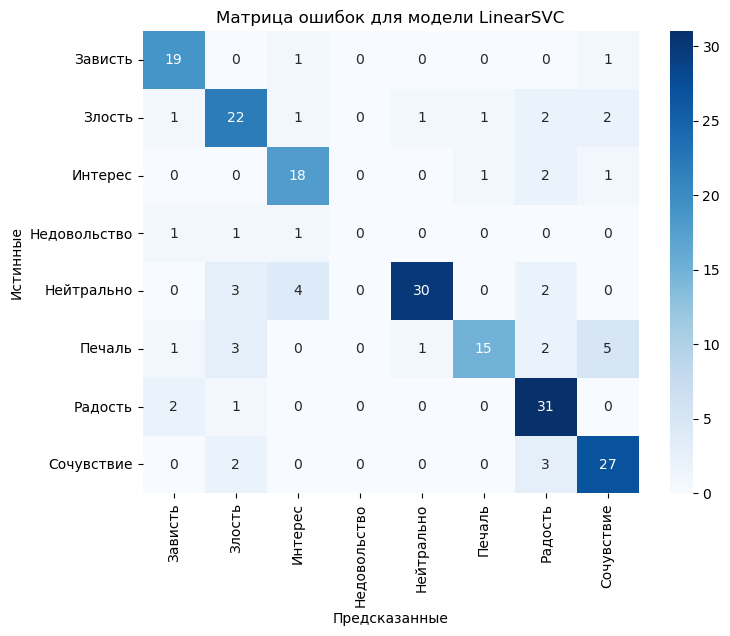

In [ ]:
# Обучение моделей и оценка их качества

# Модель Наивного Байеса
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)
print("Наивный Байес")
print(classification_report(y_test, y_pred_nb))

# Модель Логистической регрессии
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)
print("Логистическая регрессия")
print(classification_report(y_test, y_pred_lr))

# Модель LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train_vec, y_train)
y_pred_svc = svc_model.predict(X_test_vec)
print("LinearSVC")
print(classification_report(y_test, y_pred_svc))

# Матрица ошибок для лучшей модели 
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.title('Матрица ошибок для модели LinearSVC')
plt.show()